# FRI with Bandpass Kernel

This is what will be covered in this notebook:
1. [Recap](#recap): summarizes what was discussed in the previous notebook.
2. [Bandpass modification](#bp_mod): modifies the algorithm we previously saw to work for the general bandpass case.
3. [Pulse stream secovery from bandpass projection (code)](#code): applies the bandpass projection and recovery process in Python.
4. [Why bandpass?](#why): explains two scenarios in which a bandpass projection is more appropriate and links the bandpass projection to IQ demodulation.
5. [Summary](#summary): summarizes the main points of this notebook and introduces the topic of the next.

<a id='recap'></a>
# 1. Recap

In the previous tutorial, we introduced the idea of _finite rate of innovation_ (FRI), which essentially means that a signal has a finite number of degrees of freedom per unit of time. Moreover, the paper ["Sampling signals with finite rate of innovation"](https://ieeexplore.ieee.org/document/1003065/) by Vetterli et. al, made the intuitive claim that it is possible to perfectly recover an FRI signal from a discrete set of values sampled at greater than or equal to the rate of innovation. _Conversely, signals with an infinite rate of innovation cannot be perfectly recovered from their finite samples!_

A bandlimited signal (or bandlimited approximation of a non-bandlimited signal) is simply a special case of an FRI signal. Furthermore, FRI is not limited to bandlimited signals. In the above paper and in the previous notebook, we showed how to sample and perfectly reconstruct the following signal from just $2K+1$ samples over its period/duration $\tau$:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)
\end{equation}

where $h(t)$ is known. Such a signal could have infinite bandwidth, e.g. $h(t)=\delta(t)$, so a faithful representation could require a large number of samples according to the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). However, as we only have $2K$ degrees of freedom, at least $2K$ samples are sufficient for recovering the parameters $\{t_k\}_{k=0}^{K-1}$ and $\{c_k\}_{k=0}^{K-1}$. We summarize with the steps from the last notebook below:

### Pulse stream recovery procedure (baseband / lowpass)

Project $y(t)= \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)$ to a bandlimited space with the sampling kernel $s(t)$ and obtain $2K+1$ samples. The sampling kernel must have a bandwidth of at least $ 2K/\tau$ Hz. Below we use a sampling kernel bandlimited to $[-K/\tau, K/\tau]$ Hz (lowpass projection) and take samples at intervals of $T_s = \dfrac{\tau}{2K+1}$ seconds.

\begin{align}
y_{BL}[n] = (y \ast s)[nT_s], \hspace{0.5cm} n\in[0,2K]
\end{align}

Take the DFT of the obtained samples and divide by the number of samples to obtain $2K+1$ adjacent Fourier Series coefficients $\{Y_{BL}[m]\}_{m=-K}^{K}$.

\begin{equation}
\mathbf{Y}_{BL} = \dfrac{\text{DFT}([y_{BL}[0], y_{BL}[1], \ldots, y_{BL}[2K]])} {2K+1}
\end{equation}

Remove the pulse/channel shape, also known as "equalization":

\begin{align}
X[m] = \dfrac{Y_{BL}[m]}{H(m/\tau)}, \hspace{0.5cm} m\in[-K,K]
\end{align}

Solve the Yule-Walker system of equations for the annihilating filter $\mathbf{A}$, where $A[0]=1$ and $\{A[m]=0\}_{m\not\in[0,K]}$:

\begin{align}
\begin{bmatrix} 
X[0] & X[-1] &  \cdots & X[-K+1] \\ 
X[1] & X[0] &  \cdots & X[-K+2] \\
 & & \ddots &\\
X[K-1] & X[K-2] & \cdots & X[0]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
- \begin{bmatrix} X[1] \\ X[2] \\ \vdots\\ X[K]\end{bmatrix}
\end{align}

Find the $K$ zeros $\{u_k\}_{k=0}^{K-1}$ of the following polynomial:

\begin{align}
A(z) &= 1 + A[1]z^{-1} + A[2]z^{-2} + \ldots +  A[K]z^{-K}\\
&= \prod_{k=0}^{K-1} (1 - u_k z^{-1}) \\
\end{align}

Obtain the time locations $\{t_k\}_{k=0}^{K-1}$ from the zeros $\{u_k\}_{k=0}^{K-1}$:

\begin{align}
u_k &= \exp(-j2\pi t_k/\tau)\\
\Rightarrow  t_k &= \Re{(\dfrac{j \tau \ln(u_k)} {2\pi})}
\end{align}

Solve the following linear system of equations for the amplitudes $\{c_k\}_{k=0}^{K-1}$:

\begin{align}
\begin{bmatrix} X[0] \\ X[1] \\ \vdots\\ X[K-1]\end{bmatrix}
&= \dfrac{1}{\tau}
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
u_0& u_1 & \cdots & u_{K-1}\\ 
\vdots & \vdots & \cdots & \vdots \\
u_0^{K-1} & u_1^{K-1}  & \cdots & u_{K-1}^{K-1}\\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} c_0 \\ c_1 \\ \vdots\\ c_{K-1}\end{bmatrix}
\end{align}

<a id='bp_mod'></a>
# 2. Bandpass modification

In the above procedure, we used a lowpass filter in order to project our FRI signal onto a bandlimited space. However, as previously mentioned we can project our FRI signal onto **any bandlimited space** as we simply require at least $2K$ adjacent Fourier coefficients to solve for the annihilating filter for $K$ pulses. 

If we consider a Fourier coefficient index $M_c$ as our bandpass filter's center frequency index, we can apply the following projection filter/operation to obtain at least $2K$ adjacent Fourier coefficients:

\begin{equation}
S(f) = 
\begin{cases}
\text{1}, & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\in[M_c-K, M_c+K]   \\[0.5em]
\text{0},      & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\not\in[M_c-K, M_c+K]    \\[0.5em]
\text{arbitrary}, & \text{otherwise}  \\
\end{cases}
\end{equation}

For the lowpass sampling kernel, we had $M_c = 0$. To obtain the corresponding frequency $f_c$ in Hz, we just need to divide index by the period/duration $\tau$:

\begin{equation}
f_c = \dfrac{M_c}{\tau} \hspace{0.2cm} \text{[Hz]}
\end{equation}

So how does this modify the above procedure? It really only changes the indices for $X[m]$! Below we present the modified procedure.

### Pulse stream recovery procedure (general bandpass)

Project $y(t)= \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)$ to a **bandlimited** space with the sampling kernel $s(t)$ and obtain $2K+1$ samples. The sampling kernel must have a bandwidth of at least $ 2K/\tau$ Hz. Below we use a sampling kernel bandlimited to $[\dfrac{M_c-K}{\tau}, \dfrac{M_c+K}{\tau}]$ Hz (where $f_c=M_c/\tau$ is the center frequency) and take samples at intervals of $T_s = \dfrac{\tau}{2K+1}$ seconds.

\begin{align}
y_{BL}[n] = (y \ast s)[nT_s], \hspace{0.5cm} n\in[0,2K]
\end{align}

Take the DFT of the obtained samples and divide by the number of samples to obtain $2K+1$ adjacent Fourier Series coefficients $\{Y_{BL}[m]\}_{m=M_c-K}^{M_c+K}$.

\begin{equation}
\mathbf{Y}_{BL} = \dfrac{\text{DFT}([y_{BL}[0], y_{BL}[1], \ldots, y_{BL}[2K]])} {2K+1}
\end{equation}

Remove the pulse/channel shape from our projected signal in the bandlimited region, also known as "equalization":

\begin{align}
X[m] = \dfrac{Y_{BL}[m]}{H(m/\tau)}, \hspace{0.5cm} m\in[M_c-K, M_c+K] 
\end{align}

Solve the Yule-Walker system of equations for the annihilating filter $\mathbf{A}$, where $A[0]=1$ and $\{A[m]=0\}_{m\not\in[0,K]}$:

\begin{align}
\begin{bmatrix} 
X[M_c] & X[M_c-1] &  \cdots & X[M_c-K+1] \\ 
X[M_c+1] & X[M_c] &  \cdots & X[M_c-K+2] \\
 & & \ddots &\\
X[M_c+K-1] & X[M_c+K-2] & \cdots & X[M_c]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
- \begin{bmatrix} X[M_c+1] \\ X[M_c+2] \\ \vdots\\ X[M_c+K]\end{bmatrix}
\end{align}

Find the $K$ zeros $\{u_k\}_{k=0}^{K-1}$ of the following polynomial:

\begin{align}
A(z) &= 1 + A[1]z^{-1} + A[2]z^{-2} + \ldots +  A[K]z^{-K}\\
&= \prod_{k=0}^{K-1} (1 - u_k z^{-1}) \\
\end{align}

Obtain the time locations $\{t_k\}_{k=0}^{K-1}$ from the zeros $\{u_k\}_{k=0}^{K-1}$:

\begin{align}
u_k &= \exp(-j2\pi t_k/\tau)\\
\Rightarrow  t_k &= \Re{(\dfrac{j \tau \ln(u_k)} {2\pi})}
\end{align}

Solve the following linear system of equations for the amplitudes $\{c_k\}_{k=0}^{K-1}$:

\begin{align}
\begin{bmatrix} X[M_c] \\ X[M_c+1] \\ \vdots\\ X[M_c+K-1]\end{bmatrix}
&= \dfrac{1}{\tau}
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
u_0& u_1 & \cdots & u_{K-1}\\ 
\vdots & \vdots & \cdots & \vdots \\
u_0^{K-1} & u_1^{K-1}  & \cdots & u_{K-1}^{K-1}\\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} c_0 \\ c_1 \\ \vdots\\ c_{K-1}\end{bmatrix}
\end{align}

<a id='code'></a>
# 3. Pulse stream recovery from bandpass projection (code)

As seen above, we will mainly have an "index change" when recovering the pulse stream parameters from a bandpass projection, namely using a bandpass kernel centered at $f_c$ Hz but still taking at least $2K$ Fourier coefficients.

In code, our utility function from the last tutorial ``sample_ideal_project`` can take this account by setting the ``fc`` argument corresponding center frequency of our new ideal bandpass projection filter.

If our ideal box filter is centered around a frequency $f_c\neq0$, we will not have real samples anymore! That is because our new sampling kernel is not [conjugate symmetric](http://musicweb.ucsd.edu/~trsmyth/compExpAndSpecRep/Conjugate_Symmetry_Hermitia.html), i.e. we do not have equal positive and negative frequency components. This is z characteristic of real signal which we have lost by shifting our box around baseband. Therefore, our filter and our resulting samples are complex-valued.

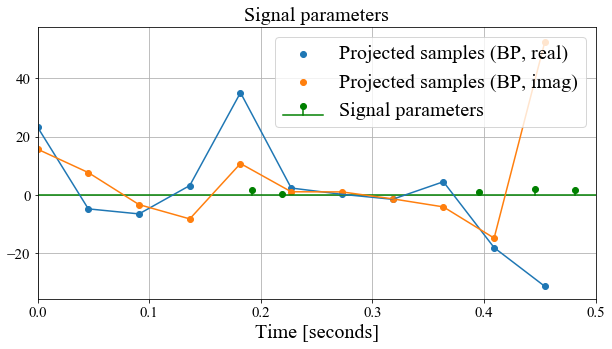

In [1]:
import numpy as np
import sys
sys.path.append('..')
import plot_settings
from frius import create_pulse_param, sample_ideal_project
figsize = (10,5)

K = 5
period = 0.5
seed = 0
fc = 500
ck, tk = create_pulse_param(K=K, period=period, seed=seed)
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period, fc=fc, viz=True, figsize=figsize)

Otherwise, we can use our same functions from before for recovering the pulse parameters as we have the necessary number of Fourier coefficients!

||tk - tk_hat||_2 = 0.000000 
||ck - ck_hat||_2 = 0.000000 


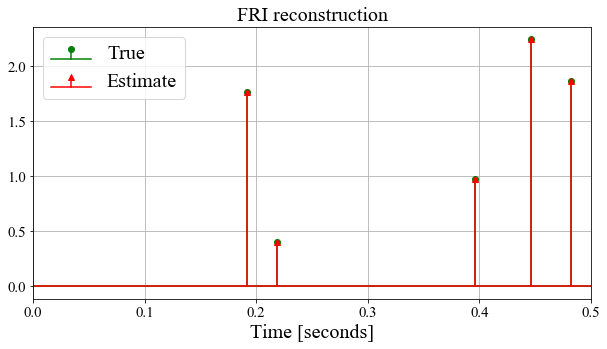

In [2]:
from frius import estimate_fourier_coeff, compute_ann_filt, estimate_time_param, estimate_amplitudes, evaluate_recovered_param

freqs = fs_ind_base/period + fc

fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp, fc=fc)
ann_filt = compute_ann_filt(fs_coeff_hat, K)
tk_hat = estimate_time_param(ann_filt, period)
ck_hat = estimate_amplitudes(fs_coeff_hat, freqs, tk_hat, period)

evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, t_max=period, figsize=figsize)

Note that certain steps of the procedure need to know what is the center frequency:
1. Estimating Fourier coefficients as we need to obtain those around the center frequency.
2. Estimating the amplitudes so that we can "invert" the following relationship for the correct frequencies/indices when solving the least-squares problem for the $c_k$'s:

\begin{align}
X[m] &= \sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi m t_k/\tau)\\
\end{align}

<a id='why'></a>
# 4. Why bandpass?

So in what situation would we want to use a bandpass projection?

Such a scenario could present itself in two ways:
1. Our sampling mechanism only returns Fourier coefficients around some frequency $f_c$.
2. Our signal is _modulated_ onto a pulse at a carrier/center frequency of $f_c$.

In both cases, the general idea is the same: the frequency response between a pulse stream and our measurements can be characterized as bandpass. For the later case, we do have the possibility of selecting our sampling kernel so we could still use a lowpass projection. In a noisy scenario though, this may hinder our recovery process. It would make more sense to obtain Fourier coefficients where we expect a higher signal power, and thus a higher _signal-to-noise ratio_ (SNR). Assuming white noise, i.e. noise that has the same level across all frequencies, it would then make sense to obtain those Fourier coefficients around the carrier/center frequency $f_c$. The influence of noise will be considered in another notebook. More on this better SNR motivation by obtaining a bandpass projection can be read [here](https://ieeexplore.ieee.org/document/997119/).

### Another perspective on the bandpass projection

In the above procedure, we described our bandpass projection in terms of discrete Fourier coefficients but we can gain additional insight by expressing our sampling process in terms of continuous functions. Our ideal lowpass box filter can be expressed as:

\begin{equation}
S_{LP}(f) = 
\begin{cases}
\text{B}, & f\in[-B/2, B/2]   \\[0.5em]
\text{0},      & \text{otherwise}  \\
\end{cases}
\end{equation}

where we multiply by $B$, the bandwidth of our filter, so that the total energy $\int_{-\infty}^{\infty}S_{LP}(f)df=1$. In the pulse stream scenario we require $B \geq \dfrac{2K}{\tau}$ for recovering the amplitudes and locations. In the time domain, our lowpass box filter can be written as:

\begin{equation}
s_{LP}(t) = B \hspace{0.1cm} \text{sinc}(Bt) = \dfrac{\sin( \pi BT)}{\pi BT}
\end{equation}

When applying an ideal bandpass filter instead, we are only shifting the center of our box filter to $f_c$, namely:

\begin{align}
S_{BP}(f) &= 
\begin{cases}
\text{B}, & f\in[f_c-B/2, \hspace{0.1cm}f_c+B/2]   \\[0.5em]
\text{0},      & \text{otherwise}  \\
\end{cases}\\[0.5em]
&= S_{LP}(f-f_c)\\
\end{align}

Moreover, shifting in one domain is multiplication with a complex exponentional in the other. So our bandpass box filter can be written in the time domain as: 

\begin{align}
s_{BP}(t) &= \exp(j2\pi f_c t) \cdot B \hspace{0.1cm} \text{sinc}(Bt) \\
&= \exp(j2\pi f_c t) \cdot s_{LP}(t) \\
\end{align}

We can immediately see why our filter is complex valued as: $\exp(j2\pi f_c t) = \cos(2\pi f_c t) + j\sin(2\pi f_c t)$, thus making our samples also complex-valued. However, what's more interesting if we _split_ our bandpass filter into two operations. We can perform the following manipulation with our bandpass kernel $s_{BP}(t)$ and the input signal $x(t)$:

\begin{align}
y(t) &= s_{BP}(t) \ast x(t)\\
&= \big(\exp(j2\pi f_c t) \cdot s_{LP}(t)\big) \ast x(t) \\
&\xrightarrow{\mathscr{F}} S_{LP}(f-f_c)\cdot X(f)\\
&= S_{LP}(f) \cdot X(f+f_c)\\
&\xrightarrow{\mathscr{F}^{-1}} s_{LP}(t) \ast \big(\exp(-j2\pi f_c t) \cdot X(f)\big)\\
\Rightarrow y(t) &= s_{LP}(t) \ast \big(\exp(-j2\pi f_c t) \cdot X(f)\big)\\
\end{align}

This is precisely [demodulation](https://en.wikipedia.org/wiki/Quadrature_amplitude_modulation#Receiver), namely first multiplying with the carrier and then lowpass filtering. The input $x(t)$ is often referred to as _Radio Frequency_ (RF) data and the output as _In-Phase and Quadrature_ (IQ) data. This type of demodulation is typically called [IQ demodulation](http://folk.ntnu.no/htorp/Undervisning/TTK10/IQdemodulation.pdf). At the link, you can find a nice introductory paper on IQ demodulation of RF data. 

<a id='summary'></a>
# 5. Summary

An essential component of our pulse steam recovery procedure, i.e. the annihilation constraint, requires us to have at least $2K$ adjacent Fourier coefficients. In the previous notebook, we used a lowpass projection to obtain those coefficients while in this notebook we generalized this procedure to any bandpass projection. We also motivated in what scenarios we would like to use a bandpass projection, e.g. noisy situations which will be considered in a later notebook and IQ demodulation.

Moreover in our code until now, we have been using a signal of the following form:

\begin{equation}
x(t) = \sum_{k=0}^{K-1}c_k\cdot \delta(t-t_k)
\end{equation}

whereas in our procedure we have discussed recovering the parameters for such a signal:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)
\end{equation}

where $h(t)$ is known so we can use its Fourier transfrom to remove the pulse/channel shape in our estimation process. In the next notebook, we will incorporate this "equalization" step to our code while applying what we have seen with applying a bandpass projection to recover the parameters from a modulated pulse stream. We will still work with noiseless data, but from the simulated samples we can make some insightful observations on why a bandpass projection is more suitable.